## Geospatial Classification

In this tutorial, you'll learn how to use different classification methods with [xarray-spatial](https://github.com/makepath/xarray-spatial) to classify the terrain elevation levels of the Grand Canyon, using data from the [NASADEM](https://aka.ms/ai4edata-nasadem) dataset.

Geospatial data [classification](http://wiki.gis.com/wiki/index.php/Classification) algorithms assign groups of data to categories, or classes, for further processing. Classification is used when grouping data points into classes for different colored areas on a choropleth map, for example. [xarray-spatial](https://github.com/makepath/xarray-spatial) is a raster analysis tool and contains different classification methods.

This tutorial walks you through:

1. Loading and rendering the area of interest data using the Grand Canyon's latitude and longitude.
2. Classifying the data using xarray-spatial's [natural breaks](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.natural_breaks.html), [equal interval](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.equal_interval.html), [quantile](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.quantile.html), and [reclassify](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.reclassify.html) functions.

This tutorial uses the [NASADEM](https://github.com/microsoft/AIforEarthDatasets#nasadem) dataset, which provides global topographic data at 1 arc-second (~30m) horizontal resolution. The data is derived primarily from data captured via the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) (SRTM) and is stored on Azure Storage in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format. The area of interest roughly covers the Grand Canyon National Park.

### Load the area of interest data

We'll use `pystac-client` to search for the COG covering Grand Canyon National Park.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
point = {"type": "Point", "coordinates": [-112.107676, 36.101690]}
search = catalog.search(collections=["nasadem"], intersects=point, limit=1)
item = next(search.get_items())
item

<Item id=NASADEM_HGT_n36w113>

This item's data can be read in using xarray's [open_rasterio](http://xarray.pydata.org/en/stable/generated/xarray.open_rasterio.html) function to load the data into an array:

In [2]:
import rioxarray

img_arr = rioxarray.open_rasterio(item.assets["elevation"].href).squeeze().drop("band")
img_arr.plot.imshow(figsize=(15, 10));

<Figure size 1080x720 with 2 Axes>

### Classify elevation data

#### Classify with `natural_breaks()`

Now let's use the [natural breaks](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.natural_breaks.html) function to classify data with the [Jenks natural breaks classification](http://wiki.gis.com/wiki/index.php/Jenks_Natural_Breaks_Classification) method. This method is designed to distribute data into classes according to clusters that form a "natural" group within the data. The algorithm minimizes the average deviation from the class mean while also maximizing the deviation from the means of the other groups. Therefore, it is generally not recommended for data with low variance.

The `num_sample` parameter allows you to control how many values to sample while calculating the groupings and has a big impact on performance. Fine-tuning `num_sample` requires an understanding of confidence intervals / margin of error along with general knowledge of the distribution of the data (e.g. are values normally distributed?). For this example we've set `num_samples=20000`.

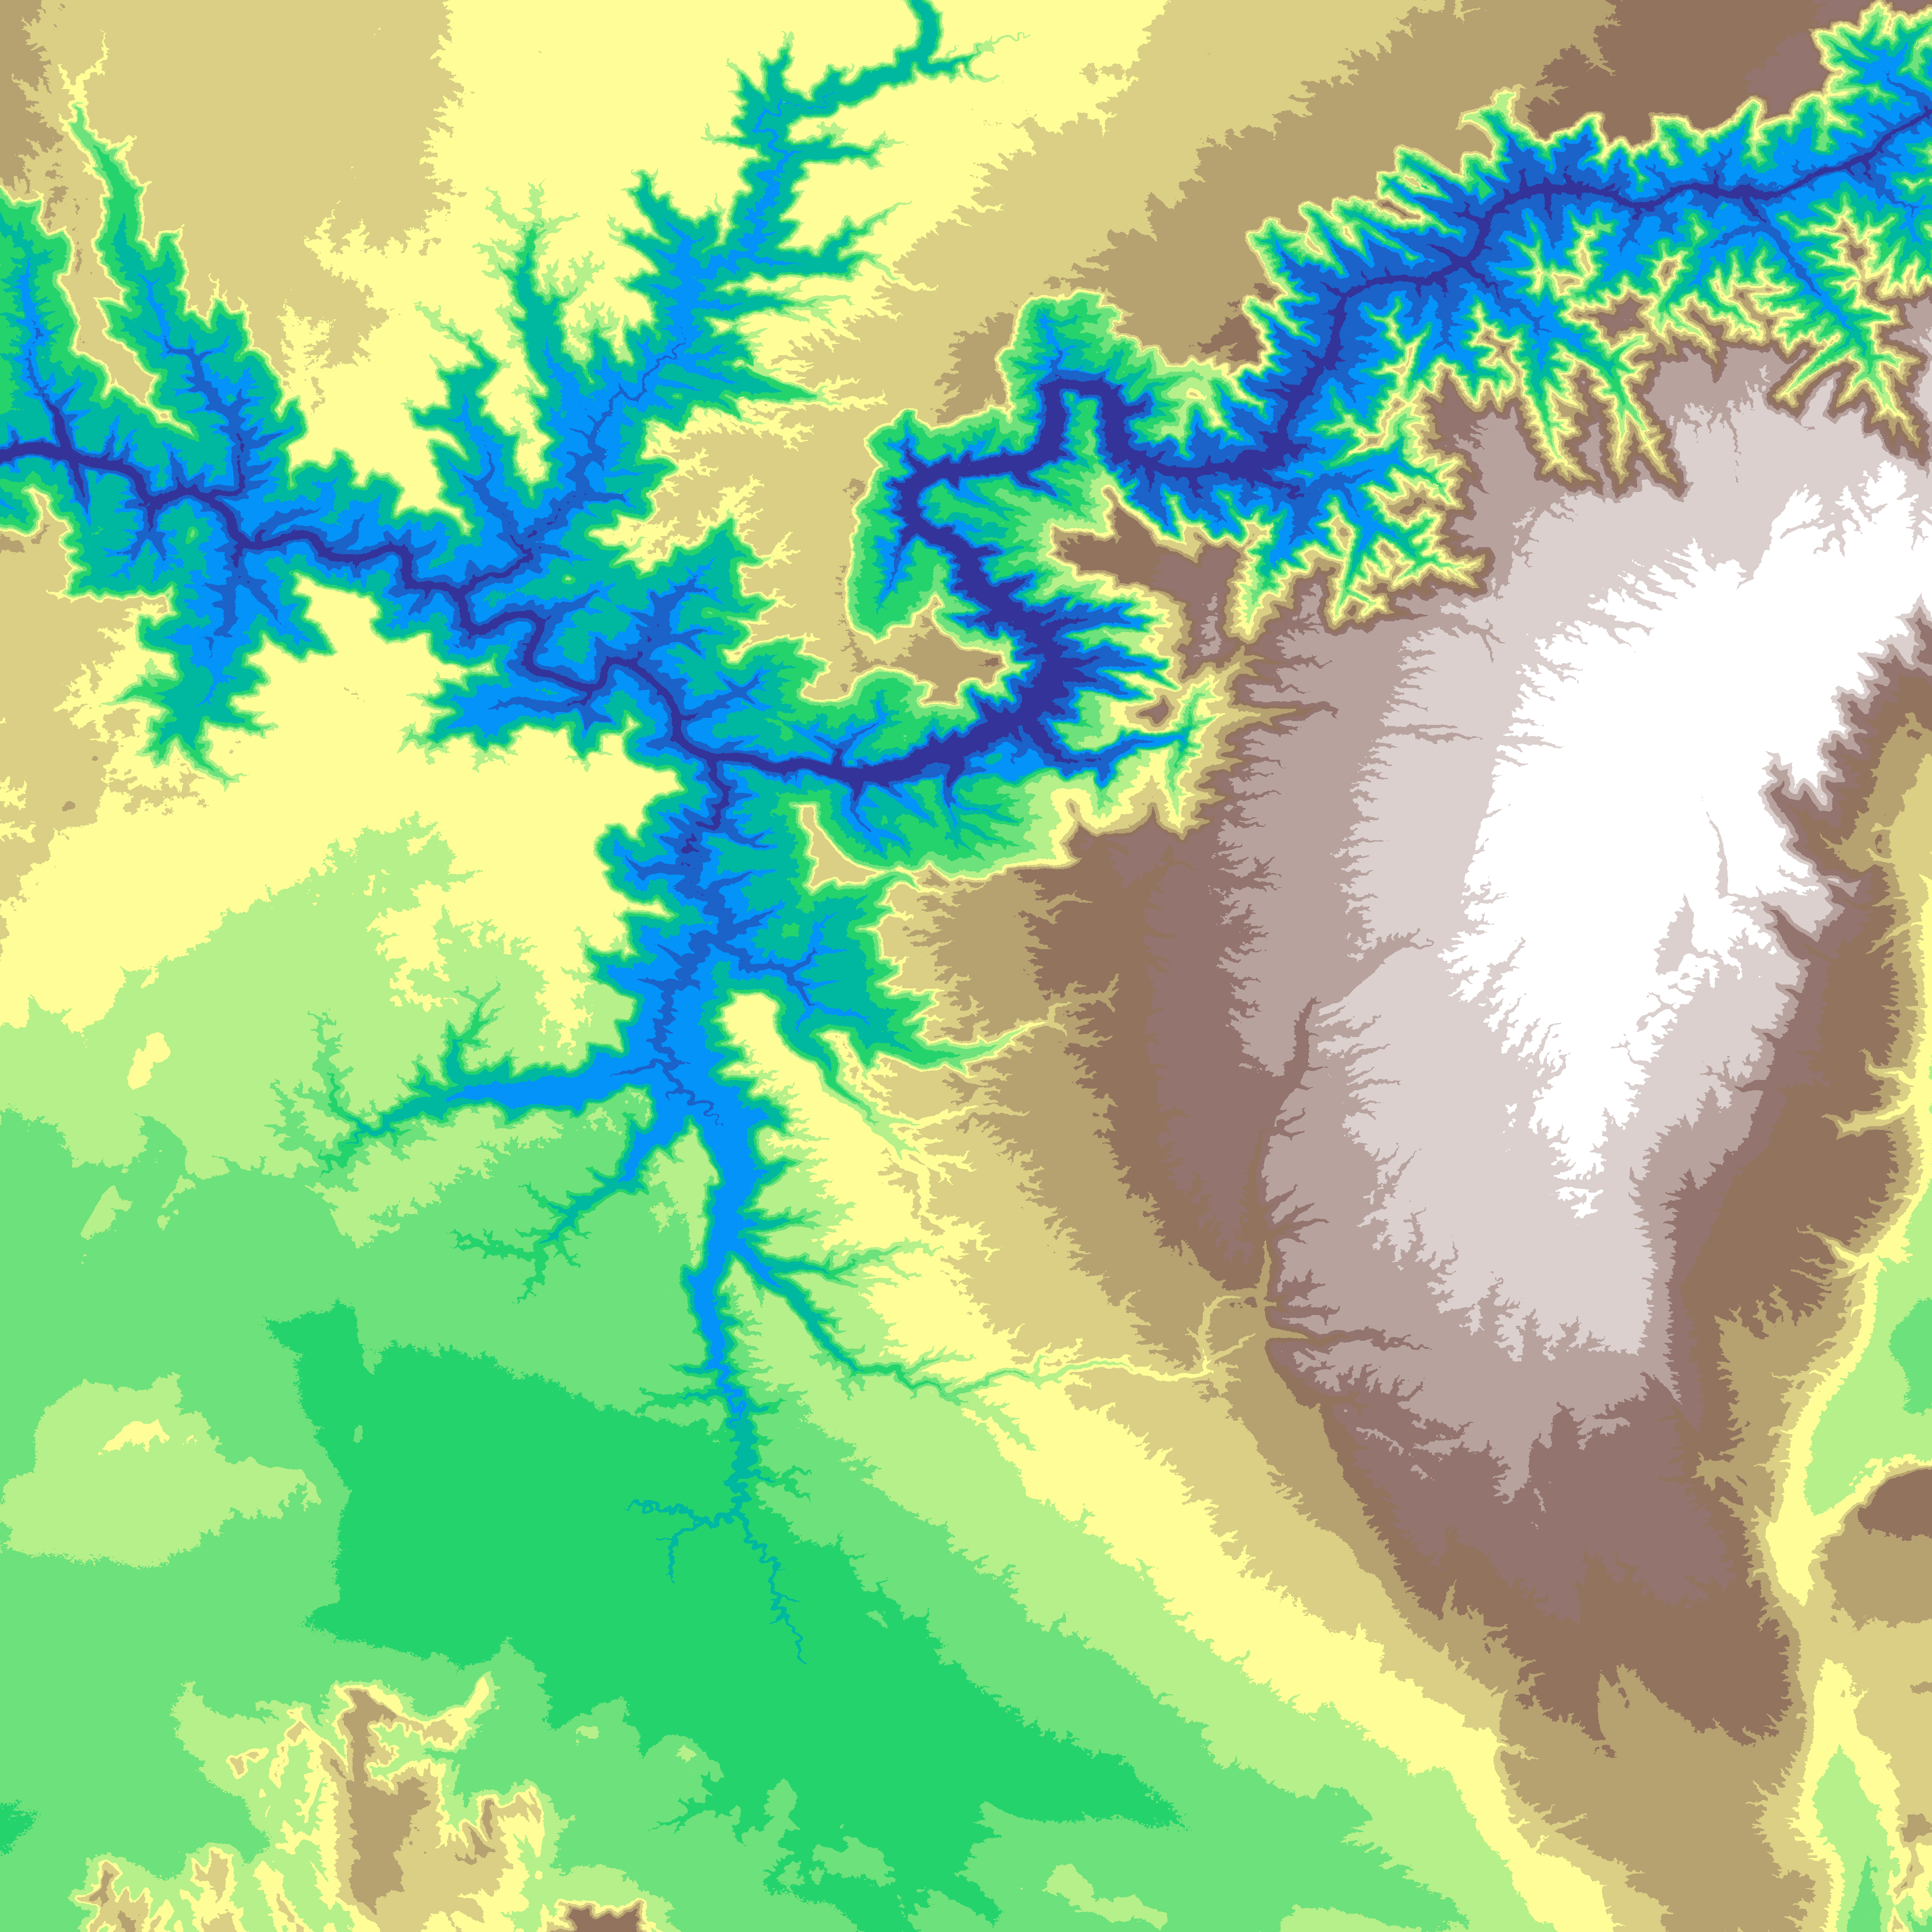

In [3]:
from datashader.transfer_functions import shade
import matplotlib.pyplot as plt
from xrspatial.classify import natural_breaks

# classify the image using natural breaks
natural_breaks_result = natural_breaks(img_arr, num_sample=20000, k=15)

shade(natural_breaks_result, cmap=plt.get_cmap("terrain"), how="linear")

You can see in the image above that the different elevation levels of the Grand Canyon are now identified by a limited number of distinct colors. Each color represents a range of values within the classified data. For example, the dark blue color areas represent the smallest elevation levels with around 700m of altitude, the yellow color areas represent elevation levels of around 1700m, and the white color areas represent the highest elevations of around 2500m of altitude.

#### Classify with `equal_interval()`

To classify data into sets based on intervals of equal width, use the [equal interval](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.equal_interval.html) function. The [equal interval classification](http://wiki.gis.com/wiki/index.php/Equal_Interval_classification) is useful in cases where you want to highlight the relative prevalence of values. As each grouping has the same range, the number of values in each group will differ.

In [4]:
from xrspatial.classify import equal_interval

equal_interval_result = equal_interval(img_arr, k=15)

shade(equal_interval_result, cmap=plt.get_cmap("terrain"), how="linear")

#### Classify with `quantile()`

To classify data based on quantile groups of equal size, use the [quantile](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.quantile.html) function. With [quantile classification](http://wiki.gis.com/wiki/index.php/Quantile), each class contains the same number of data points. This means that each class is equally represented on the map. However, intervals of uneven sizes can lead to an over-weighting of outliers and other effects.

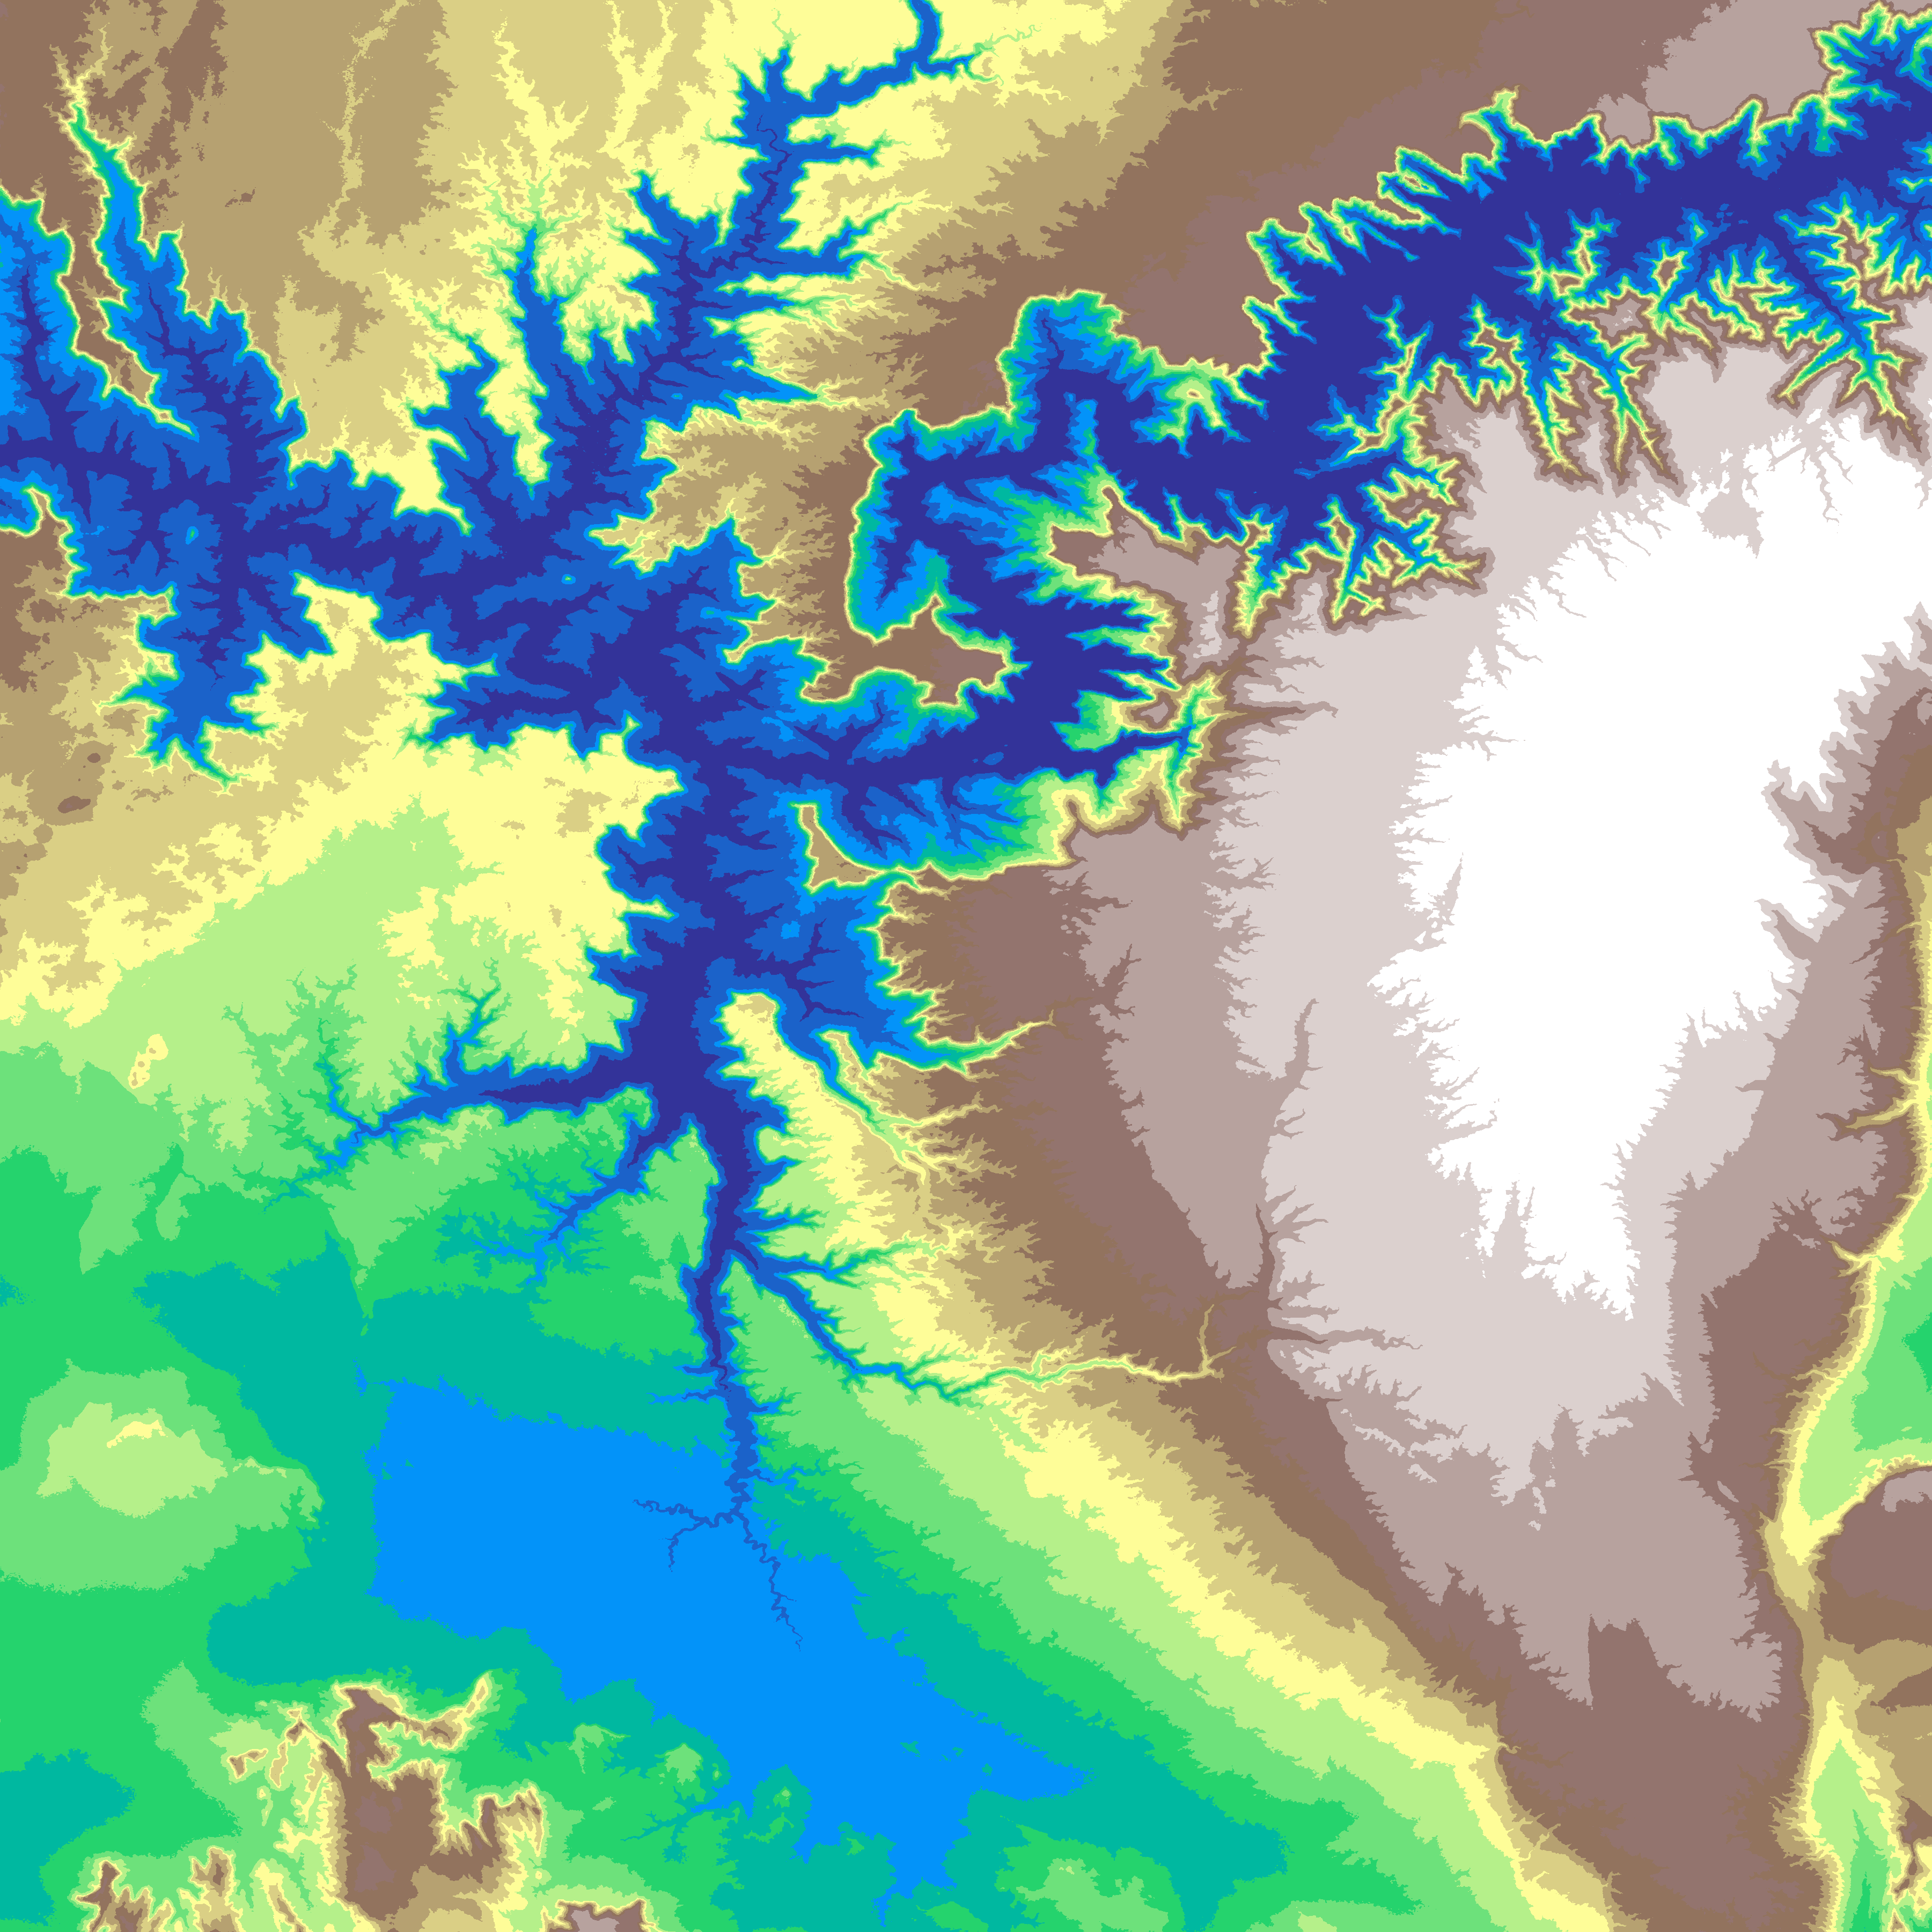

In [5]:
from xrspatial.classify import quantile

quantile_result = quantile(img_arr, k=15)

shade(quantile_result, cmap=plt.get_cmap("terrain"), how="linear")

### Use custom bins with `reclassify`

To define your own arbitrary bins to classify data, use the [reclassify](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.reclassify.html) function. This function is helpful to highlight specific sections of your data, for example. Use `reclassify()` to only visualize elevations greater than 2500m:

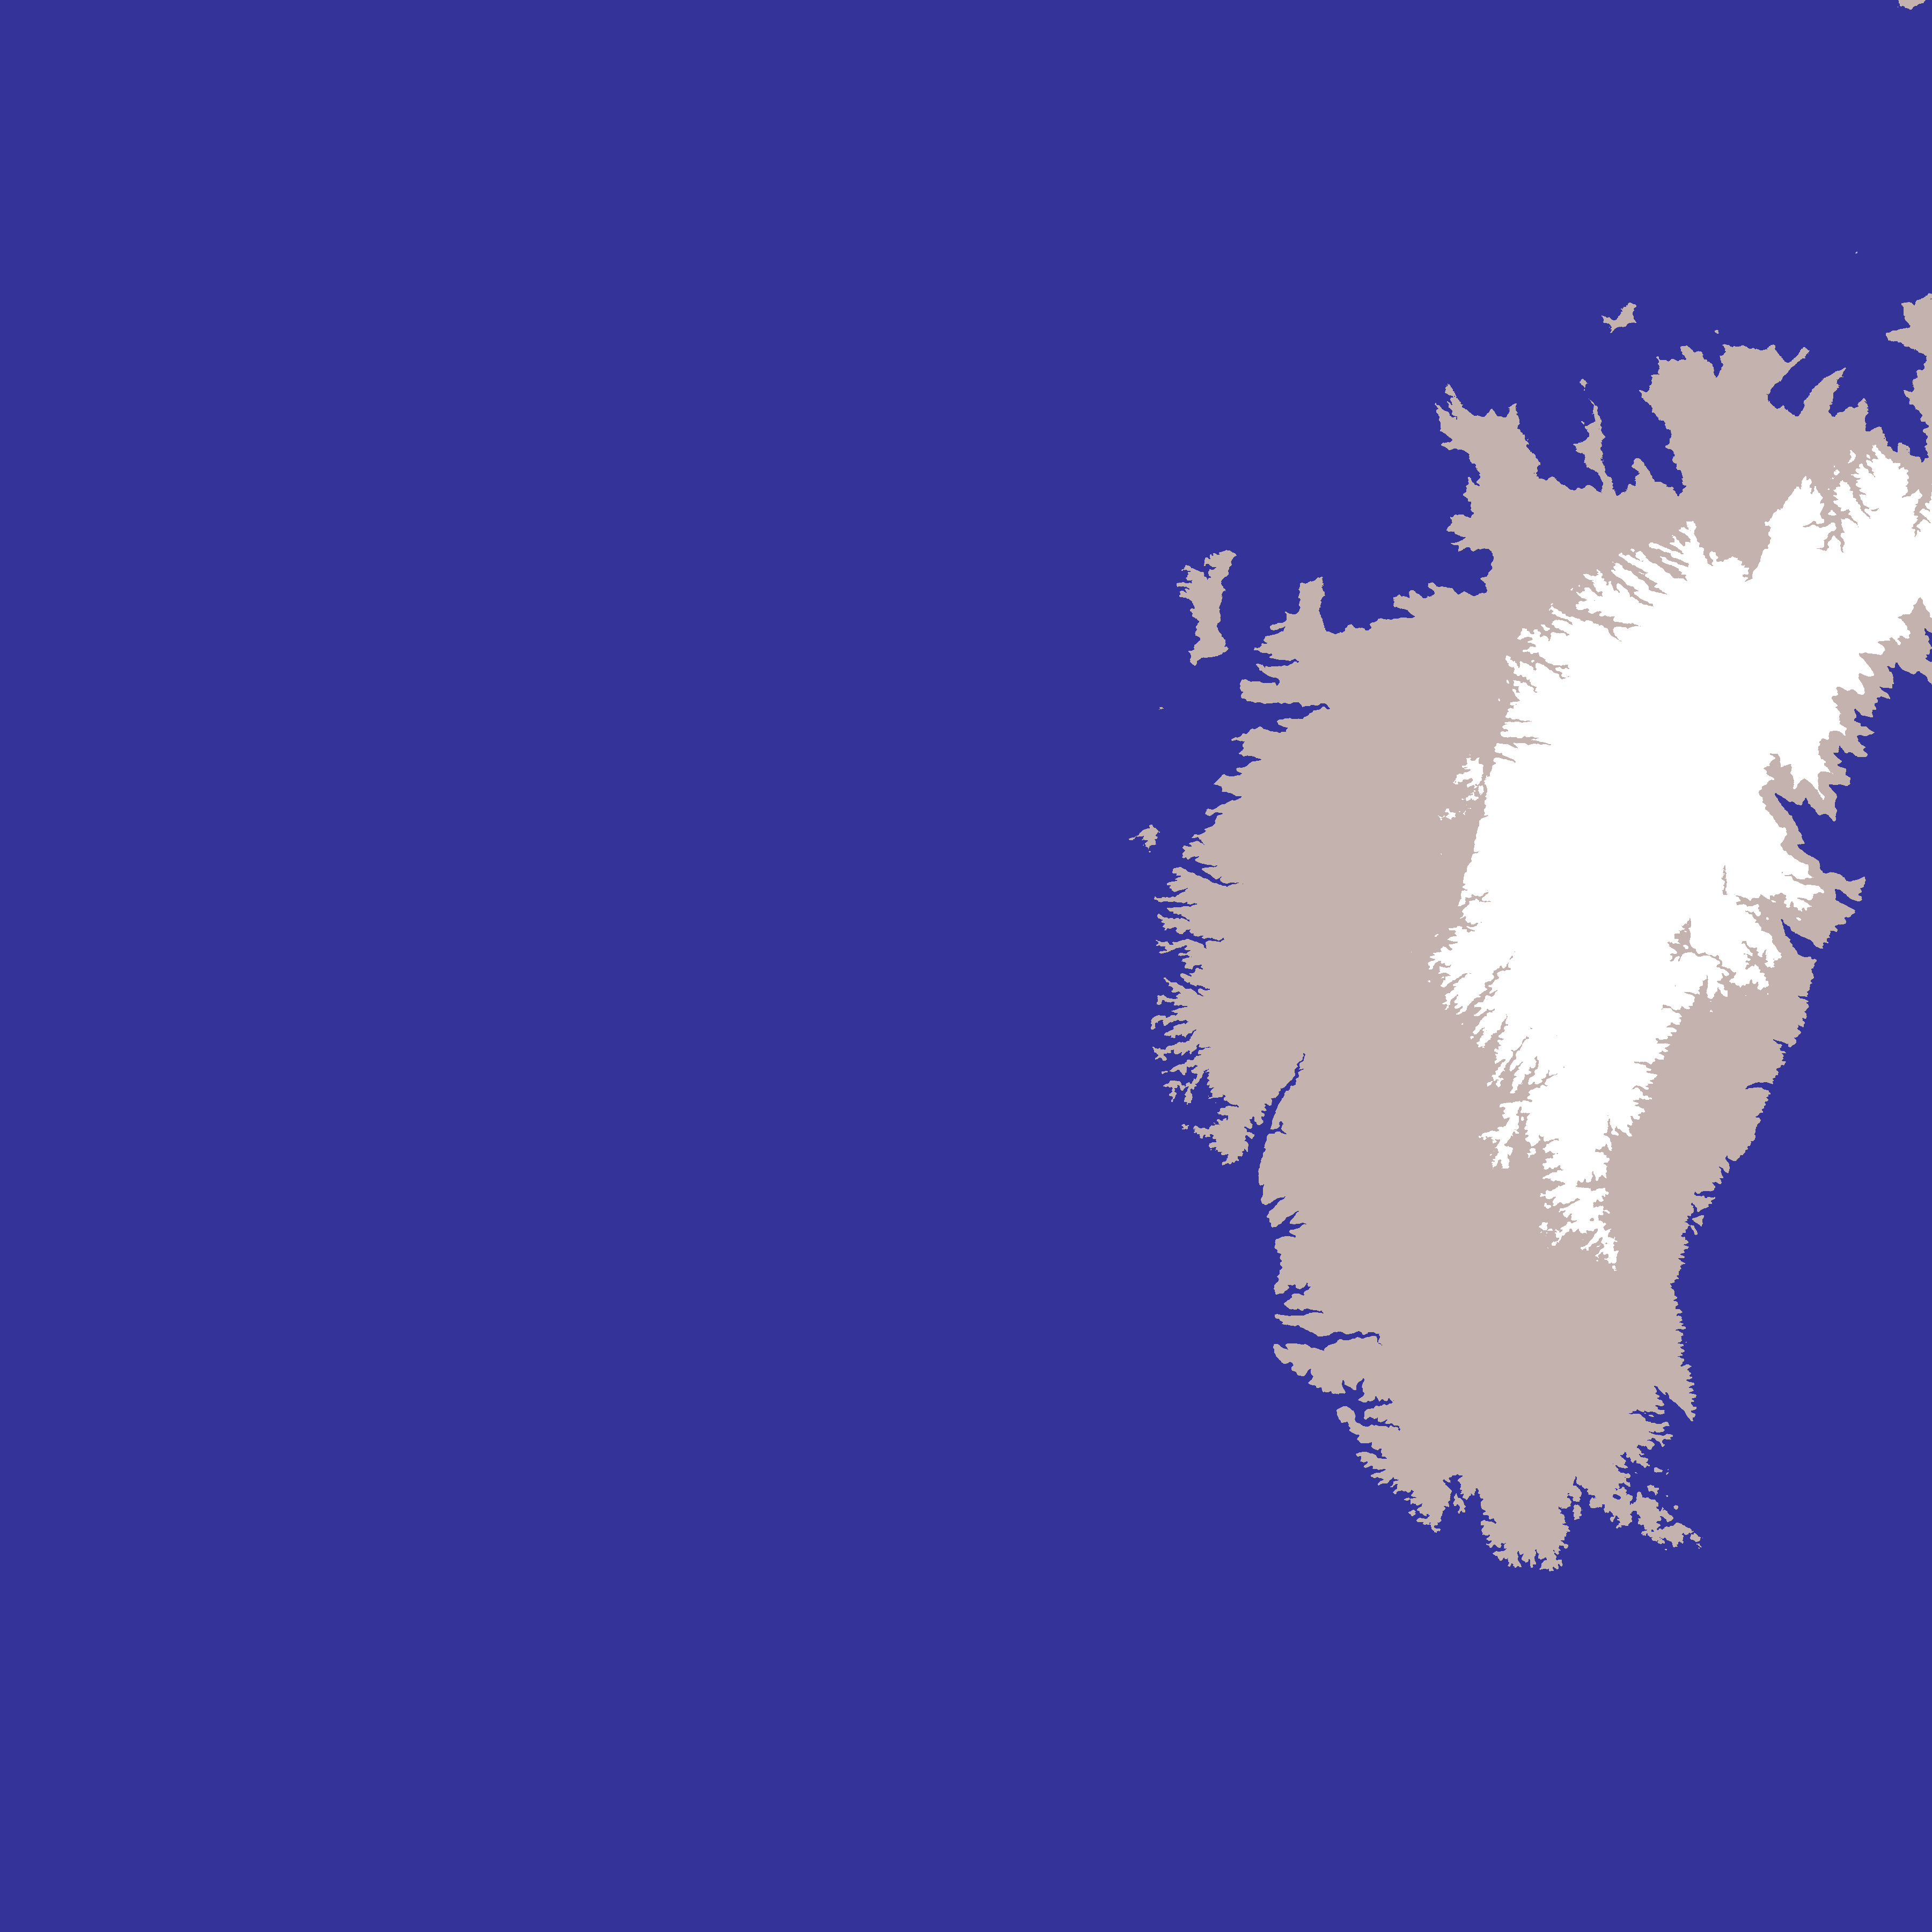

In [6]:
from xrspatial.classify import reclassify

bins = range(150, 5200, 350)
new_vals = [val if val > 2500 else 0 for val in bins]

reclass_result = reclassify(
    agg=img_arr,
    bins=bins,
    new_values=new_vals,
)

shade(reclass_result, cmap=plt.get_cmap("terrain"), how="linear")

### Next steps: classify different datasets

The [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog) includes petabytes of environmental monitoring data. All data sets are available in consistent, analysis-ready formats. You can access them through APIs as well as directly via [Azure Storage](https://docs.microsoft.com/en-us/azure/storage/). 

Try using [xarray-spatial's](https://xarray-spatial.org/index.html) classification methods with these datasets:

<div style="width: 100%; overflow: hidden;">
     <div style="width: 50%; float: left;"> 
  
  <center><img src="https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/additional_datasets/RE3CbUs.jpg" /></center>
<br>
<center><font size="5">Daymet</font>
<center><font size="2">Gridded temperature data across North America</font>
<center><a href="http://aka.ms/ai4edata-daymet" target="_blank">Get Daymet temperature data</a>
  </div>
     <div style="margin-left: 50%;"> 
  <center><img src="https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/additional_datasets/gbif.jpg" /><center>
<br>
<center><font size="5">GBIF</font>
<center><font size="2">Species occurrences shared through the Global Biodiversity Information Facility</font>
<center><a href="http://aka.ms/ai4edata-gbif/" target="_blank">Get GBIF occurrence data</a>
  </div>
</div>